# Standard Regression (BQML)

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available
# on an “as is,” “as available,” and “with all faults” basis, solely for
# illustrative purposes, and without warranty or representation of any kind.
# This solution is experimental, unsupported and provided solely for your
# convenience. Your use of it is subject to your agreements with Google, as
# applicable, and may constitute a beta feature as defined under those
# agreements.  To the extent that you make any data available to Google in
# connection with your use of the solution, you represent and warrant that you
# have all necessary and appropriate rights, consents and permissions to permit
# Google to use and process that data.  By using any portion of this solution,
# you acknowledge, assume and accept all risks, known and unknown, associated
# with its usage, including with respect to your deployment of any portion of
# this solution in your systems, or usage in connection with your business,
# if at all.
###########################################################################

## 0) Dependencies

In [136]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'OnStar_RBA' #add proj name and dataset

In [137]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = project_name #update project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False


# data processing libraries
import numpy as np
import pandas as pd


# modeling and metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

!pip install relativeImp
from relativeImp import relativeImp


# visutalization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from google.colab import files

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## 1) Import dataset

Import the data using the bigquery magics (%% command).
Pulls all of the data from the cleaned data table and stores into a dataframe "df"

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
# %%bigquery df
# SELECT *
# FROM `.RBA_demo.cleaned_data`
# ORDER BY date; #update project name

In [138]:
#update file name
file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data.csv'
df_raw = pd.read_csv(file_name)
df_raw.fillna(0, inplace=True)
df=df_raw.drop(columns=['DIV_WYG_PPl21_0p0_0d0_12'],axis=1).copy()
df.head()

,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_12,C_DIV_BUY_SSl21_0p0_0d0_06,C_DIV_CONN_DATAl21_0p0_0d0_06,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_06,...,DIV_PKG_CONN_SERVICESl21_0p0_0d0_06,DIV_PLANPAGE_ESSl21_0p0_0d0_0,OC_APP_Accessl21_0p0_0d0_12,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_06,Is_Holiday
0,10/13/2023,729,-1.108161,0.178209,-0.774452,0.627772,-0.264759,-0.146654,-0.311050,1.422696,...,0.152846,-0.690469,-0.624894,-0.189886,-1.329793,-0.263140,-0.970183,0.060408,-0.310528,0
1,10/14/2023,936,-0.591641,-1.339583,-0.210658,-0.060092,1.589453,-0.647853,0.225988,0.828675,...,-0.092741,-0.717841,-0.191100,-0.421855,-0.885066,-0.368436,-0.970183,-0.082952,0.649707,0
2,10/15/2023,787,-1.532171,-1.826123,-1.843573,-1.182772,-1.070458,-1.485678,0.973487,-1.001415,...,-0.817821,-0.772585,-0.320066,-1.336846,-1.405619,-1.460062,-0.970183,-0.144391,-1.107704,0
3,10/16/2023,1030,-0.780518,-1.196795,-0.373532,0.178700,-0.684164,-0.640373,-1.523014,-0.602030,...,-0.080364,-0.714270,1.079373,1.429066,0.473788,0.647186,0.539693,0.026275,-1.216410,0
4,10/17/2023,950,-0.965540,-0.985256,-0.277478,-1.161387,-0.375129,-0.902193,-1.312554,0.123433,...,2.984049,-0.288221,0.529403,1.571362,-0.316369,0.114966,-0.788998,-0.977240,-1.216410,0


In [139]:
df.columns

Index(['Date', 'A_OC_GOOGLE_SHOPPING', 'C_DIV_BUY_CONNECTEDl21_0p0_0d0_12',
       'C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12', 'C_DIV_BUY_PREMIUMl21_0p0_0d0_12',
       'C_DIV_BUY_SSl21_0p0_0d0_06', 'C_DIV_CONN_DATAl21_0p0_0d0_06',
       'C_DIV_CONN_REMOTEl21_0p0_0d0_12', 'C_DIV_CONN_TRYl21_0p0_0d0_06',
       'C_DIV_GETNOW_CONNl21_0p0_0d0_06', 'C_DIV_GETNOW_ESSl21_0p0_0d0_12',
       'C_DIV_GETNOW_PREMl21_0p0_0d0_12', 'C_DIV_GETNOW_SSl21_0p0_0d0_12',
       'C_PP_PKG_APP_ACCESSl21_0p0_0d0_12', 'C_PP_PKG_CONNECTEDl21_0p0_0d0_12',
       'C_PP_PKG_ESSl21_0p0_0d0_12', 'C_PP_PKG_PREMl21_0p0_0d0_12',
       'C_PP_PKG_REMOTEl21_0p0_0d0_0', 'C_PP_PKG_SCl21_0p0_0d0_12',
       'C_PP_PKG_SSl21_0p0_0d0_12', 'DIV_GMOC_SHOP_ESSl21_0p0_0d0_0',
       'DIV_GMOC_SHOP_SSl21_0p0_0d0_0', 'DIV_PKG_CONN_SERVICESl21_0p0_0d0_06',
       'DIV_PLANPAGE_ESSl21_0p0_0d0_0', 'OC_APP_Accessl21_0p0_0d0_12',
       'OC_PAGE_PREFl21_0p0_0d0_06', 'OC_PAGE_PREFPLl21_0p0_0d0_12',
       'OC_PAGE_PREMl21_0p0_0d0_12', 'SC_BUY

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Date                                 91 non-null     object 
 1   A_OC_GOOGLE_SHOPPING                 91 non-null     int64  
 2   C_DIV_BUY_CONNECTEDl21_0p0_0d0_12    91 non-null     float64
 3   C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12   91 non-null     float64
 4   C_DIV_BUY_PREMIUMl21_0p0_0d0_12      91 non-null     float64
 5   C_DIV_BUY_SSl21_0p0_0d0_06           91 non-null     float64
 6   C_DIV_CONN_DATAl21_0p0_0d0_06        91 non-null     float64
 7   C_DIV_CONN_REMOTEl21_0p0_0d0_12      91 non-null     float64
 8   C_DIV_CONN_TRYl21_0p0_0d0_06         91 non-null     float64
 9   C_DIV_GETNOW_CONNl21_0p0_0d0_06      91 non-null     float64
 10  C_DIV_GETNOW_ESSl21_0p0_0d0_12       91 non-null     float64
 11  C_DIV_GETNOW_PREMl21_0p0_0d0_12   

Flag variables will be unique to each use case. Be sure to include the most accurate control variables and flags that represent the most relevant adjustments to your data.

In [141]:
df.head()

,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_12,C_DIV_BUY_SSl21_0p0_0d0_06,C_DIV_CONN_DATAl21_0p0_0d0_06,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_06,...,DIV_PKG_CONN_SERVICESl21_0p0_0d0_06,DIV_PLANPAGE_ESSl21_0p0_0d0_0,OC_APP_Accessl21_0p0_0d0_12,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_06,Is_Holiday
0,10/13/2023,729,-1.108161,0.178209,-0.774452,0.627772,-0.264759,-0.146654,-0.311050,1.422696,...,0.152846,-0.690469,-0.624894,-0.189886,-1.329793,-0.263140,-0.970183,0.060408,-0.310528,0
1,10/14/2023,936,-0.591641,-1.339583,-0.210658,-0.060092,1.589453,-0.647853,0.225988,0.828675,...,-0.092741,-0.717841,-0.191100,-0.421855,-0.885066,-0.368436,-0.970183,-0.082952,0.649707,0
2,10/15/2023,787,-1.532171,-1.826123,-1.843573,-1.182772,-1.070458,-1.485678,0.973487,-1.001415,...,-0.817821,-0.772585,-0.320066,-1.336846,-1.405619,-1.460062,-0.970183,-0.144391,-1.107704,0
3,10/16/2023,1030,-0.780518,-1.196795,-0.373532,0.178700,-0.684164,-0.640373,-1.523014,-0.602030,...,-0.080364,-0.714270,1.079373,1.429066,0.473788,0.647186,0.539693,0.026275,-1.216410,0
4,10/17/2023,950,-0.965540,-0.985256,-0.277478,-1.161387,-0.375129,-0.902193,-1.312554,0.123433,...,2.984049,-0.288221,0.529403,1.571362,-0.316369,0.114966,-0.788998,-0.977240,-1.216410,0


Set KPI and date columns

In [142]:
kpi_col = "A_OC_GOOGLE_SHOPPING" #@param {type:"string"}

In [143]:
date_col = "Date" #@param {type:"string"}

## 2) Run the RBA Model

This model also includes a train/test split of 90/10 using the "data_split_method", "data_split_eval_fraction", and "data_split_col" parameters.

Since this data is time series, we use a sequential split with the date column as the reference point.

We suggest using a train/test split to validate model performance, but for attribution results we suggest running the model on the full dataset.

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [11]:
# %%bigquery
# REATE OR REPLACE MODEL `test.model`  #update project name
# OPTIONS (model_type='linear_reg',
#         data_split_method = 'SEQ', #use these options for train/test splits
#         data_split_eval_fraction = 0.1,
#         data_split_col = 'date',
#         input_label_cols = ['y1'],
#         enable_global_explain = True)
# AS SELECT * EXCEPT(date)
#     FROM df
#     ORDER BY date; #update project name

In [144]:

# Load your DataFrame 'df' and sort it by date
df = df.sort_values(by='Date')

# Define the fraction for the test set
test_fraction = 0.05

# Compute the index at which to split the data
split_index = int((1 - test_fraction) * len(df))

# Split the data into training and testing sets
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Define the features (X) and target (y)
X_train = train_df.drop([kpi_col, date_col], axis=1)
y_train = train_df[kpi_col]
X_test = test_df.drop([kpi_col, date_col], axis=1)
y_test = test_df[kpi_col]

# Create and fit the model
model_train = LinearRegression()
model_train.fit(X_train, y_train)



LinearRegression()

In [145]:
# Load your DataFrame 'df' and sort it by date
df = df.sort_values(by='Date')

# Define the features (X) and target (y)
X_all = df.drop([kpi_col, date_col], axis=1)
y_all = df[kpi_col]

# Create and fit the model
model_all = LinearRegression()
model_all.fit(X_all, y_all)


LinearRegression()

### 2.1) Print the model evaluation metrics

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Call the model evaluation metrics from the model and save to a dataframe "evaluation_metrics".

For linear regression models The ML.EVALUATE function returns the following error metrics: mean absolute error, mean squared erorr, mean squared log error, median absolute error, r-squared, and explained variance metrics.

In [ ]:
# %%bigquery evaluation_metrics
# SELECT *
# FROM ML.EVALUATE(MODEL `.RBA_demo.RBA_model`) #update project name

In [ ]:
# evaluation_metrics

In [146]:
# Predict using the model
y_test_pred = model_train.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
median_ae = median_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
explained_variance = explained_variance_score(y_test, y_test_pred)

# Save to a DataFrame
evaluation_metrics = pd.DataFrame({
    'Mean Absolute Error': [mae],
    'Mean Squared Error': [mse],
    'Median Absolute Error': [median_ae],
    'R-squared': [r2],
    'Explained Variance': [explained_variance]
})

evaluation_metrics


,Mean Absolute Error,Mean Squared Error,Median Absolute Error,R-squared,Explained Variance
0,210.459876,57593.310554,234.114976,0.52651,0.890658


In [147]:
# Predict using the model
y_pred = model_all.predict(X_all)

# Calculate evaluation metrics
mse = mean_squared_error(y_all, y_pred)
mae = mean_absolute_error(y_all, y_pred)
median_ae = median_absolute_error(y_all, y_pred)
r2 = r2_score(y_all, y_pred)
explained_variance = explained_variance_score(y_all, y_pred)

# Save to a DataFrame
evaluation_metrics = pd.DataFrame({
    'Mean Absolute Error': [mae],
    'Mean Squared Error': [mse],
    'Median Absolute Error': [median_ae],
    'R-squared': [r2],
    'Explained Variance': [explained_variance]
})

evaluation_metrics


,Mean Absolute Error,Mean Squared Error,Median Absolute Error,R-squared,Explained Variance
0,95.875452,15917.203508,79.768118,0.963979,0.963979


In [148]:
import statsmodels.api as sm

# Assuming X_all is your features and y_all is the target variable
X_all = sm.add_constant(X_all)  # Adding a constant to the model
model = sm.OLS(y_all, X_all).fit()  # Fit the model

# Get the summary
model_summary = model.summary()
print(model_summary)


                             OLS Regression Results                             
Dep. Variable:     A_OC_GOOGLE_SHOPPING   R-squared:                       0.964
Model:                              OLS   Adj. R-squared:                  0.946
Method:                   Least Squares   F-statistic:                     53.52
Date:                  Thu, 25 Jan 2024   Prob (F-statistic):           3.48e-33
Time:                          21:55:05   Log-Likelihood:                -569.34
No. Observations:                    91   AIC:                             1201.
Df Residuals:                        60   BIC:                             1279.
Df Model:                            30                                         
Covariance Type:              nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

### 2.2) Visualize model fit

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Select the predicted conversions (y1) of the model and actual conversions from the data (y1) using the ML.PREDICT function

In [ ]:
# %%bigquery model_predictions
# SELECT
#   *
# FROM
#   ML.PREDICT(MODEL `.RBA_demo.RBA_model`, #update project name
#     (
#     SELECT
#         *
#     FROM
#       `.RBA_demo.cleaned_data`
#       ORDER BY date)); #update project name

Visualize the model fit by comparing predicted vs. actual data.

In [34]:
# results = pd.DataFrame()
# results['actual'] = df[kpi_col]
# results['predicted'] = model_predictions.predicted_y1

In [149]:
# Predict
predicted_y = model_all.predict(df.drop([kpi_col, date_col], axis=1))

# Create a DataFrame for results
results = pd.DataFrame()
results['actual'] = df[kpi_col]  # Replace kpi_col with your actual KPI column name
results['predicted'] = predicted_y

In [150]:
# Assuming you have a DataFrame 'test_df' with features and actual values, and 'model' is your trained model


# Create the model_predictions DataFrame
model_predictions = df[[kpi_col]].copy()  # Actual values
model_predictions['predicted_y1'] = predicted_y

# Calculate residuals
model_predictions['residuals'] = model_predictions['predicted_y1'] - model_predictions[kpi_col]
#model_predictions.head()

In [151]:
fig = px.line(results.sort_index())
fig.show()

## 3) Calculate contribution of each digital tactic on conversions

### 3.1) Relative Importance

Use the [relativeImp](https://pypi.org/project/relativeImp/) package to conduct key driver analysis and generate relative importance values by feature in the model.


The relativeImp function produces a raw relative importance and a normalized relative importance value.

- Raw relative importance sums to the r-squared of the linear model.
- Normalized relative importance is scaled to sum to 1

In [152]:
conversions = kpi_col
df = df.drop(columns = date_col)
tactics = df[df.columns[df.columns != conversions]].columns.to_list()
relative_importance_results = relativeImp(df,
                                          outcomeName = conversions,
                                          driverNames = tactics)

In [124]:
relative_importance_results.sort_values(by = 'rawRelaImpt', ascending = False)

,driver,rawRelaImpt,normRelaImpt
18,DIV_GMOC_SHOP_ESSl21_0p0_0d0_0,0.353694,36.690997
21,DIV_PLANPAGE_ESSl21_0p0_0d0_0,0.128719,13.352928
19,DIV_GMOC_SHOP_SSl21_0p0_0d0_0,0.054886,5.693664
13,C_PP_PKG_ESSl21_0p0_0d0_12,0.044718,4.638872
20,DIV_PKG_CONN_SERVICESl21_0p0_0d0_06,0.029900,3.101676
25,OC_PAGE_PREMl21_0p0_0d0_12,0.029207,3.029888
15,C_PP_PKG_REMOTEl21_0p0_0d0_0,0.029196,3.028697
14,C_PP_PKG_PREMl21_0p0_0d0_12,0.029059,3.014497
1,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,0.028764,2.983888
23,OC_PAGE_PREFl21_0p0_0d0_06,0.026991,2.799983


In [153]:
round(relative_importance_results.rawRelaImpt.sum(),2) #Model's R-squared

0.96

## 4) Validate Linear Regression Model Assumptions

For any statistical model it is important to validate model assumptions.
With RBA, we validate the standard linear model assumptions of:

  - Linearity
  - Normality of errors
  - Absence of multicollinearity
  - Homoscedasticity
  - Absence of autocorrelation of residuals



If any of the model assumptions fail, a different model specification, as well as re-examination of the data should be considered

Incorrect model use can lead to unreliable results

### 4.1) Generate residuals

Calculate model residuals as the difference from predicted y1 values and actual y1 values


In [154]:
model_predictions['residuals'] = model_predictions.predicted_y1 - model_predictions[kpi_col]

### 4.2) Linearity

Visually inspect linearity between target variable (y1) and predictions

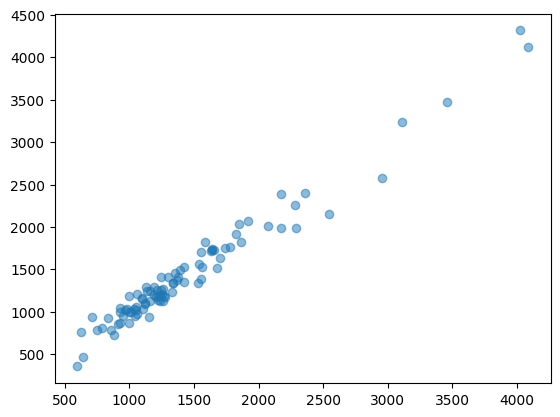

In [155]:
plt.plot(model_predictions.predicted_y1,model_predictions[kpi_col],'o',alpha=0.5)
plt.show()

### 4.3) Normality of Errors

Visually inspect the residuals to confirm normality

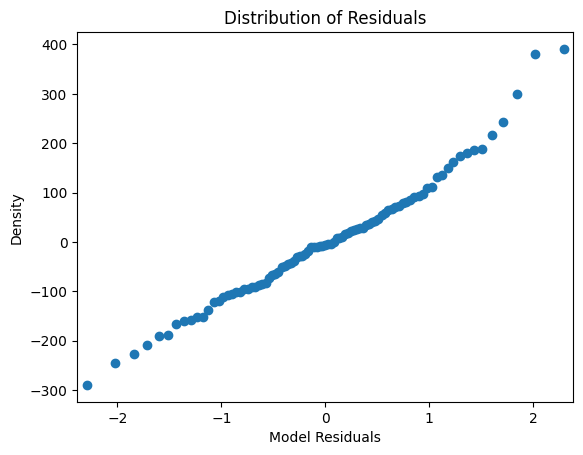

In [156]:
fig = sm.qqplot(model_predictions.residuals)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

### 4.4) Homoscedasticity


Visually inspect residuals to confirm constant variance

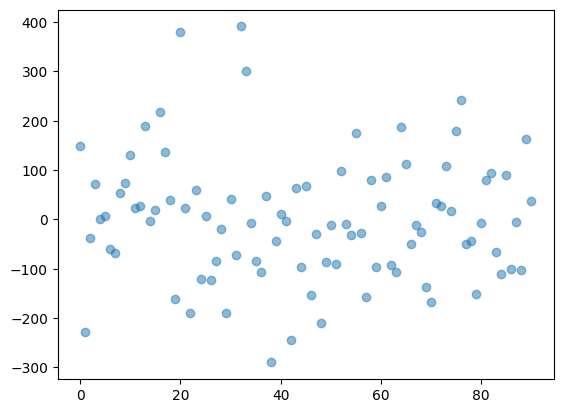

In [157]:
plt.plot(model_predictions.residuals,'o',alpha=0.5)
plt.show()

### 4.5) Absence of Autocorrelation of the residuals

The Durbin Watson test is a statistical test for detecting autocorrelation of the model residuals

In [158]:
dw = durbin_watson(model_predictions.residuals)
print('Durbin-Watson',round(dw,1))

Durbin-Watson 1.8


In [159]:
if dw < 1.5:
        print('Positive autocorrelation', '\n')
elif dw > 2.5:
        print('Negative autocorrelation', '\n')
else:
        print('Little to no autocorrelation', '\n')


Little to no autocorrelation 



In [160]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Assuming 'df' is your DataFrame with all the predictor variables
X = df.drop('A_OC_GOOGLE_SHOPPING', axis=1)  # Assuming 'y1' is your target variable

# Add a constant to the model (if it's not already included)
X = sm.add_constant(X)

# Calculating VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


                                feature       VIF
0                                 const  1.272103
1     C_DIV_BUY_CONNECTEDl21_0p0_0d0_12  4.111839
2    C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12  3.686145
3       C_DIV_BUY_PREMIUMl21_0p0_0d0_12  2.226791
4            C_DIV_BUY_SSl21_0p0_0d0_06  3.365000
5         C_DIV_CONN_DATAl21_0p0_0d0_06  1.613624
6       C_DIV_CONN_REMOTEl21_0p0_0d0_12  3.527130
7          C_DIV_CONN_TRYl21_0p0_0d0_06  1.969358
8       C_DIV_GETNOW_CONNl21_0p0_0d0_06  2.726344
9        C_DIV_GETNOW_ESSl21_0p0_0d0_12  1.837377
10      C_DIV_GETNOW_PREMl21_0p0_0d0_12  2.486879
11        C_DIV_GETNOW_SSl21_0p0_0d0_12  2.878256
12    C_PP_PKG_APP_ACCESSl21_0p0_0d0_12  2.096711
13     C_PP_PKG_CONNECTEDl21_0p0_0d0_12  4.220834
14           C_PP_PKG_ESSl21_0p0_0d0_12  6.868734
15          C_PP_PKG_PREMl21_0p0_0d0_12  9.777067
16         C_PP_PKG_REMOTEl21_0p0_0d0_0  7.327730
17            C_PP_PKG_SCl21_0p0_0d0_12  2.112160
18            C_PP_PKG_SSl21_0p0_0d0_12  3.426324


## 5) Export Final Results

In [161]:
final_results_df = relative_importance_results[['driver','rawRelaImpt']]
final_results_df.to_csv('rba_final_output_Std_Reg.csv', encoding = 'utf-8-sig')
files.download('rba_final_output_Std_Reg.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>